In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import time
from IPython.display import clear_output

import tf_utils as tfu

import context_learning as ctl

In [4]:
np.arange(0, 1.0 + 0.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [8]:
np.linspace(0, 1, 10 + 1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [2]:
strategy = tfu.strategy.gpu(1)

2022-02-14 09:38:28.096687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 09:38:28.097067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 09:38:28.101314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 09:38:28.101691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 09:38:28.102448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [45]:
x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

y_train = np.array([
    [0, 0, 0, 1], # AND
    [0, 1, 1, 1], # OR
    [1, 1, 1, 0], # NAND
    [1, 0, 0, 0], # NOR
    [0, 1, 1, 0], # XOR
    [1, 0, 0, 1], # XNOR
    [0, 0, 1, 1], # Custom A
    [0, 1, 0, 1], # Custom B
])[..., np.newaxis]

data_labels = ["AND", "OR", "NAND", "NOR", "XOR", "XNOR", "Custom A", "Custom B"]

In [46]:
BATCH_SIZE = 1

datasets = []
for y in y_train:
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y)).batch(BATCH_SIZE)
    dist_dataset = strategy.experimental_distribute_dataset(dataset)
    datasets.append(dist_dataset)
clear_output() # hide shard warnings

In [83]:
ATR_SIZE = 128
SWITCH_THRESHOLD = -0.02

with strategy.scope():
    y = x = keras.layers.Input((2,))
    y = keras.layers.Dense(ATR_SIZE, activation="relu")(y)
    y = ctl.ContextLayer(switch_threshold=SWITCH_THRESHOLD, num_contexts=2, auto_switch=False)(y)
    y = keras.layers.Dense(ATR_SIZE)(y)
    y = ctl.ContextLayer(switch_threshold=SWITCH_THRESHOLD, num_contexts=2, auto_switch=False)(y)
    y = keras.layers.Dense(1, activation="sigmoid")(y)
    model = ctl.ContextModel(x, y, verbose=1, retry_fit=False)
    model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(from_logits=False))
    model.summary()
    # model.run_eagerly=True

Model: "context_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               384       
_________________________________________________________________
context_layer_15 (ContextLay (None, 128)               13        
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
context_layer_16 (ContextLay (None, 128)               13        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 17,052
Trainable params: 17,025
Non-trainable params: 27
______________________________________________

In [84]:
history = {
    "loss": [],
    "context_losses": [[] for _ in range(model.num_context_layers)],
    "context_deltas": [[] for _ in range(model.num_context_layers)],
}

epoch = -1

In [85]:
context_map = [
    (0, 0,), # AND
    (1, 1,), # NAND
    (1, 0,), # OR
    (0, 1,), # NOR
]

context_sequence = []

In [86]:
train = ctl.make_train_function(eager=False)
initial = True

with strategy.scope():
    for _ in range(4):
        # for i in np.random.permutation(len(context_map)):
        for i in range(len(context_map)):
            dataset = datasets[i]
            
            # Append the context to the squence
            context_sequence.append(i)
            
            # No autoswitching: set to the initial state
            if initial:
                print("Initializing context mapping...")
                initial = False
                for j, context in enumerate(context_map[i]):
                    model.layers[model.context_layer_map[j]].set_context(context)
            
            # Perform a training epoch
            for epoch in range(epoch+1, epoch+100 + 1):
                while model.perform_epoch(epoch, context_map=context_map[i]):
                    history["loss"].append(0)
                    for batch in dataset:
                        loss = train(model, batch, strategy)
                        history["loss"][-1] += loss
                    print(f"\rEpoch: {epoch}; Dataset: {i}; Loss: {loss}", end="")
                
                for j, layer in enumerate(model.context_layer_map):
                    history["context_losses"][j].append(model.layers[layer].context_losses.value())
                    history["context_deltas"][j].append(model.layers[layer].delta.value())

Initializing context mapping...


2022-02-14 10:08:05.648141: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 100; Dataset: 1; Loss: 0.001332793035544455Switch to 1
Switch to 1
Epoch: 200; Dataset: 2; Loss: 8.119686126708984Switch to 0
Epoch: 300; Dataset: 3; Loss: 0.0017401904333382845Switch to 0
Switch to 1
Epoch: 400; Dataset: 0; Loss: 8.430572509765625Switch to 0
Epoch: 500; Dataset: 1; Loss: 0.0014410465955734253Switch to 1
Switch to 1
Epoch: 539; Dataset: 1; Loss: 0.0026196017861366276

2022-02-14 10:08:35.670948: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 600; Dataset: 2; Loss: 6.9130377769470215Switch to 0
Epoch: 700; Dataset: 3; Loss: 0.0015104208141565323Switch to 0
Switch to 1
Epoch: 800; Dataset: 0; Loss: 7.191049575805664Switch to 0
Epoch: 900; Dataset: 1; Loss: 0.0010684250155463815Switch to 1
Switch to 1
Epoch: 1000; Dataset: 2; Loss: 6.943772315979004Switch to 0
Epoch: 1077; Dataset: 2; Loss: 0.0020538636017590766

2022-02-14 10:09:05.689034: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 1100; Dataset: 3; Loss: 0.001224343664944172Switch to 0
Switch to 1
Epoch: 1200; Dataset: 0; Loss: 7.0624895095825195Switch to 0
Epoch: 1300; Dataset: 1; Loss: 0.0011440127855166793Switch to 1
Switch to 1
Epoch: 1400; Dataset: 2; Loss: 6.898181915283203Switch to 0
Epoch: 1500; Dataset: 3; Loss: 0.0012335076462477446Switch to 0
Switch to 1
Epoch: 1599; Dataset: 3; Loss: 0.0008476022630929947

### Hierarchy: (AND/NOR, NAND/OR) -> (AND/OR, NAND/NOR)

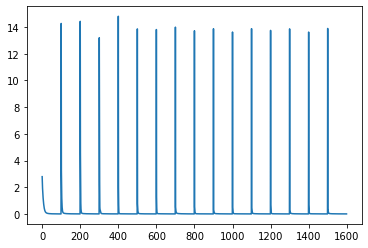

In [87]:
plt.plot(history["loss"])

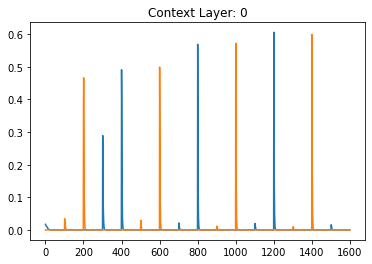

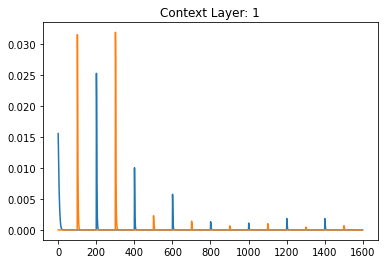

In [88]:
for layer_id, l in enumerate(history["context_losses"]):
    plt.title(f"Context Layer: {layer_id}")
    for i, ctx in enumerate(np.array(l).T):
        plt.plot(ctx)
    plt.show()

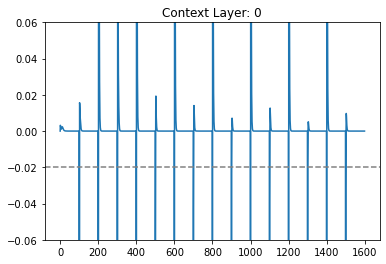

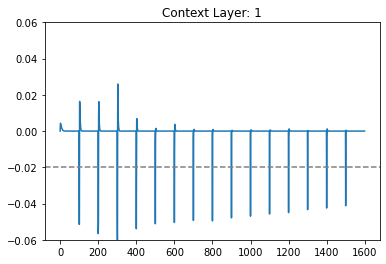

In [89]:
for layer_id, delta in enumerate(history["context_deltas"]):
    plt.title(f"Context Layer: {layer_id}")
    plt.plot(delta)
    plt.axhline(y=model.layers[2].switch_threshold.value(), color="gray", linestyle="--")
    plt.ylim([-0.06, 0.06])
    plt.show()

### Hierarchy: Negate -> AND/OR

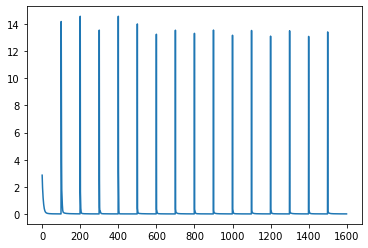

In [69]:
plt.plot(history["loss"])

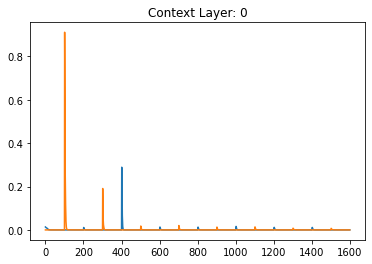

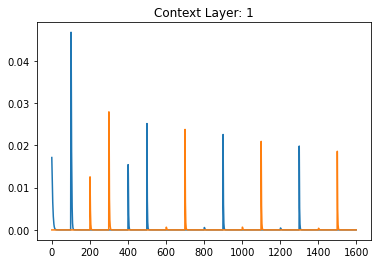

In [70]:
for layer_id, l in enumerate(history["context_losses"]):
    plt.title(f"Context Layer: {layer_id}")
    for i, ctx in enumerate(np.array(l).T):
        plt.plot(ctx)
    plt.show()

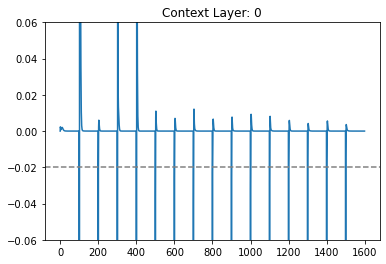

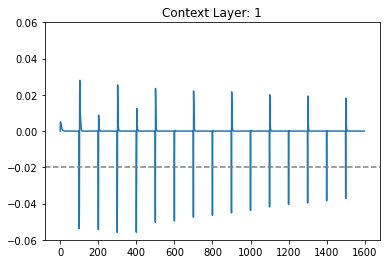

In [71]:
for layer_id, delta in enumerate(history["context_deltas"]):
    plt.title(f"Context Layer: {layer_id}")
    plt.plot(delta)
    plt.axhline(y=model.layers[2].switch_threshold.value(), color="gray", linestyle="--")
    plt.ylim([-0.06, 0.06])
    plt.show()

### Hierarchy: And/OR -> Negate

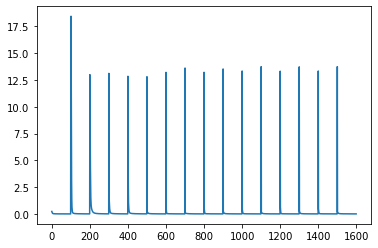

In [80]:
plt.plot(history["loss"])

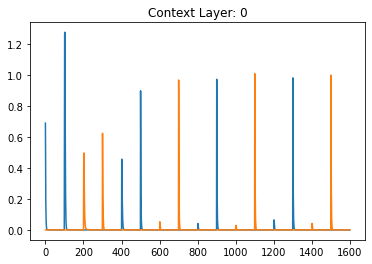

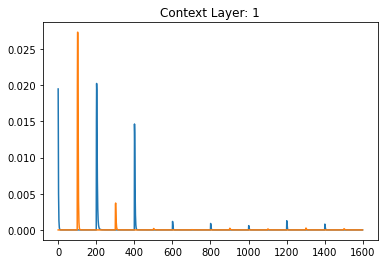

In [81]:
for layer_id, l in enumerate(history["context_losses"]):
    plt.title(f"Context Layer: {layer_id}")
    for i, ctx in enumerate(np.array(l).T):
        plt.plot(ctx)
    plt.show()

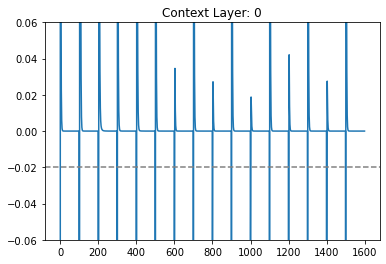

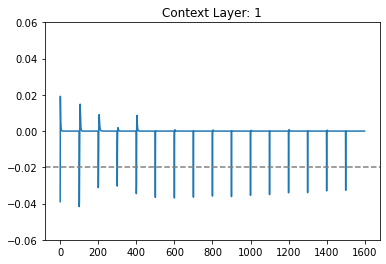

In [82]:
for layer_id, delta in enumerate(history["context_deltas"]):
    plt.title(f"Context Layer: {layer_id}")
    plt.plot(delta)
    plt.axhline(y=model.layers[2].switch_threshold.value(), color="gray", linestyle="--")
    plt.ylim([-0.06, 0.06])
    plt.show()